Sophie van Dijke (s3567826) Assignment 2

In [70]:
from model import Model
from dmchunk import Chunk

import math
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Define noise, time_to_pulses, and pulses_to_time:

In [71]:
def noise(s):
    rand = random.uniform(0.001,0.999)
    return s * math.log((1-rand)/rand)

In [72]:
def time_to_pulses(time, t_0=0.011, a =1.1, b = 0.015):
    pulses = 0
    pulse_duration = t_0
    while time >=0: # pulse duration
        time -=pulse_duration
        pulses+=1
        pulse_duration = a * pulse_duration + noise(b * a * pulse_duration)
    return pulses

In [73]:
def pulses_to_time(pulses, t_0 = 0.011, a = 1.1, b = 0.015):
    time = 0
    pulse_duration = t_0
    while pulses > 0:
        time = time + pulse_duration
        pulses = pulses -1
        pulse_duration = a * pulse_duration + noise(b * a * pulse_duration)
    return time

Define the three conditions and their intervals:

In [74]:
cond1 = np.array([494.09, 529.38, 564.67, 599.96, 635.26, 670.55, 705.84, 741.13, 776.42, 811.72, 847.01])
cond2 = np.array([670.55, 705.84, 741.13, 776.42, 811.72, 847.01, 882.3, 917.59, 952.88, 988.18, 1023.5])
cond3 = np.array([847.01, 882.3, 917.59, 952.88, 988.18, 1023.5, 1058.8, 1094.1, 1129.3, 1164.6, 1199.9])

Define model:

In [75]:
def ready_set_go(n_participants, trials = 1500, tr_train=500):
    results = []
    conditions = {
        1: cond1,
        2: cond2,
        3: cond3
    }

    for i in range(1, n_participants + 1):
        for j, condition in conditions.items():
            model = Model()
            for trial in range(1, trials+1):
                # fixation point
                model.time += 1
                # random delay
                model.time += np.random.uniform(0.25, 0.85)
                # time interval for this trial, chosen at random
                t_s = np.random.choice(condition)
                # convert trial interval into pulses
                t_m = time_to_pulses(t_s)
                # store as chunk
                fact = Chunk(name="p-" + str(t_m), slots={"isa": "pulse-num", "pulses": t_m})
                model.add_encounter(fact)
                model.time += 0.05
                # blended memory retrieval
                request = Chunk(name="blended-request", slots={"isa": "pulse-num"})
                t_e, latency = model.retrieve_blended_trace(request, "pulses")
                model.time += latency
                t_p = pulses_to_time(t_e)
                # classify the first 500 trials as training trials (Main = FALSE)
                main_value = trial >= tr_train
                results.append([i, j, trial, trial, t_s, t_p, 1000, main_value])

    columns = ["Subj", "Cond", "line", "Trial", "Ts", "Tp", "MaxTrial", "Main"]
    df_results = pd.DataFrame(results, columns=columns)

    return df_results

Run the model

In [76]:
dat = ready_set_go(5)

print(dat)

       Subj  Cond  line  Trial       Ts           Tp  MaxTrial   Main
0         1     1     1      1   635.26   818.572688      1000  False
1         1     1     2      2   564.67   543.895068      1000  False
2         1     1     3      3   494.09   609.732064      1000  False
3         1     1     4      4   564.67   953.521581      1000  False
4         1     1     5      5   670.55  1066.512608      1000  False
...     ...   ...   ...    ...      ...          ...       ...    ...
22495     5     3  1496   1496  1129.30  2276.767398      1000   True
22496     5     3  1497   1497  1094.10  1089.488387      1000   True
22497     5     3  1498   1498  1164.60  1360.954385      1000   True
22498     5     3  1499   1499  1164.60  1817.606756      1000   True
22499     5     3  1500   1500   952.88  1171.173414      1000   True

[22500 rows x 8 columns]


Plot the results

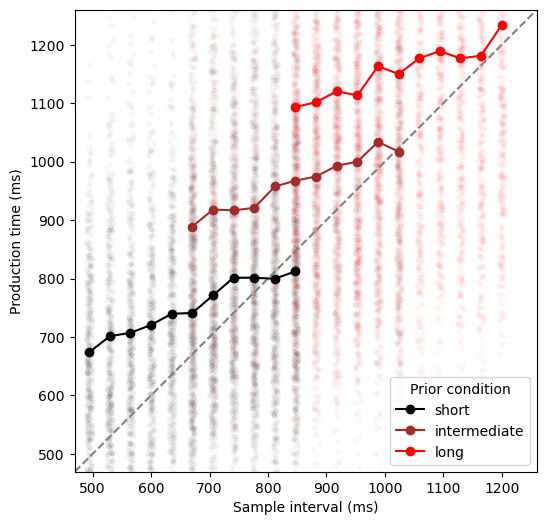

In [77]:
# Remove training trials
dat = dat[dat['Main'] == True]

# Calculate mean Tp by condition
mean_tp = dat.groupby(['Cond', 'Ts'])['Tp'].mean().reset_index()


yrange = np.multiply((min(mean_tp['Ts']), max(mean_tp['Ts'])), [0.95, 1.05])

# Subset data for plotting

cond1 = mean_tp.loc[mean_tp['Cond'] == 1]
cond2 = mean_tp.loc[mean_tp['Cond'] == 2]
cond3 = mean_tp.loc[mean_tp['Cond'] == 3]

# Add jitter noise
jitter = dat.copy()
jitter['Ts'] = jitter['Ts'] + np.random.uniform(-5, 5, len(dat))
cond1_jitter = jitter.loc[jitter['Cond'] == 1]
cond2_jitter = jitter.loc[jitter['Cond'] == 2]
cond3_jitter = jitter.loc[jitter['Cond'] == 3]

# Make plot
f, ax = plt.subplots(figsize = (6,6))

ax.set(xlim = yrange, ylim = yrange)
f.gca().set_aspect('equal', adjustable = 'box')

ax.set_xlabel('Sample interval (ms)')
ax.set_ylabel('Production time (ms)')

ax.plot(yrange, yrange, linestyle = '--', color ='gray')

ax.scatter(cond1_jitter['Ts'], cond1_jitter['Tp'], marker = '.', color = 'black', alpha = 0.025, label = None)
ax.scatter(cond2_jitter['Ts'], cond2_jitter['Tp'], marker = '.', color = 'brown', alpha = 0.025, label = None)
ax.scatter(cond3_jitter['Ts'], cond3_jitter['Tp'], marker = '.', color = 'red', alpha = 0.025, label = None)

ax.plot(cond1['Ts'], cond1['Tp'], color = 'black', marker = 'o', label = "short")
ax.plot(cond2['Ts'], cond2['Tp'], color = 'brown', marker = 'o', label = "intermediate")
ax.plot(cond3['Ts'], cond3['Tp'], color = 'red', marker = 'o', label = "long")

ax.legend(title = 'Prior condition', loc = 4)

My model, initialized from zero for each condition, takes the time interval (t_s), converts it to pulses (t_m), and stores this pulse information a chunk in the working memory of the model. The model then performs a blended retrieval of the chunks to generate the expected pulses (t_e), which is then converted to the predicted time (t_p) that the participant inputs during the experiment. In this system, chunks with the same number of pulses are combined, thereby increasing activation and increasing proportion in the blended memory retrieval. This process iterates 1500 times for each subject in each condition. The resulting graph from my model is an approximation of the data, however there are some discrepancies. Most notably, my model produces longer predictions than what was seen in the data, resulting in a left shift of the condition lines in the plot. However, my model does appear to show somewhat the systematic regression towards the mean with increasing time intervals. Overall, I think it is a fair approximation, but I was not able to determine the cause of the left-shift of my lines in the plot, which poses the largest limitation to my model.